# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use linear regression with feature selection for performing some simple analysis on real neural signals.

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders (= # of features)
* Select the optimal features via cross-validation
  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand position from the neural signals from the motor cortex.

We first load the basic packages.

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [14]:
import urllib.request
import scipy.io

url = "https://raw.githubusercontent.com/sdrangan/introml/master/unit04_model_sel/StevensonV2.mat"
urllib.request.urlretrieve(url, "StevensonV2.mat")

mat_dict = scipy.io.loadmat("StevensonV2.mat")


The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [15]:
#TODO
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

We extract two variables, `spikes` and `handPos`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand position.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handPos` data, we take the second component which is the position of monkey's hand.

In [16]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handPos'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [17]:
# TODO
mat_dict['spikes'].shape
print(mat_dict['spikes'].shape)

(196, 15536)


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [18]:
# TODO
time = mat_dict['time'][0]
tsamp = time[1] - time[0]
ttotal = time[-1] - time[0]

## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [19]:
# TODO
# Xtr = ...
Xtr = mat_dict['spikes'][:, :7768].T
# ytr = ...
ytr = mat_dict['handPos'][0, :7768]
# Xts = ...
Xts = mat_dict['spikes'][:, 7768:].T
# yts = ...
yts = mat_dict['handPos'][0, 7768:]

Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [20]:
import sklearn.linear_model

# TODO
reg = sklearn.linear_model.LinearRegression()
reg.fit(Xtr, ytr)

print(reg.coef_)
print(reg.intercept_)

[-8.12905437e-04  3.48937870e-03  3.81984436e-03  3.18467001e-03
  6.04836232e-04  2.76165348e-03 -3.61875764e-03  3.40328593e-03
 -2.51298657e-03  1.45434028e-03  3.50711184e-03  6.87652298e-03
  9.86913163e-04  5.94305421e-16  6.28055755e-04 -9.89642463e-05
  1.30038704e-03 -1.38340114e-02 -3.00270155e-03 -5.34887320e-03
 -1.98045923e-03 -2.99406174e-04  2.32675365e-03 -2.49724396e-04
  2.98405784e-02 -8.83172075e-04  1.38220758e-03  1.00696139e-04
 -1.24020003e-02  5.83530231e-04 -7.63522332e-04  6.15666999e-04
  1.79873582e-03  7.19257877e-05  6.75951467e-04 -1.12110227e-03
 -4.25383126e-04  1.43237882e-02  1.97003548e-03  3.17901746e-03
 -2.60491818e-02 -2.47241463e-15  2.52721743e-03  5.83725589e-04
 -9.53746524e-06  1.71955235e-03 -2.51709152e-03 -8.26626193e-04
 -2.45534570e-02 -1.01387153e-02 -2.86797405e-03 -7.51036359e-04
  2.18639403e-03 -3.35980923e-03  7.21522360e-04  3.03345499e-03
  2.93251529e-03  3.90661191e-03  7.83251210e-03  2.04594958e-03
  9.06107441e-04  1.41071

Measure and print the normalized RSS on the test data.  

In [21]:
# TODO
y_pred = reg.predict(Xtr)
RSS_train = np.mean((y_pred - ytr)**2)/(np.std(ytr)**2)
Rsq_train = 1-RSS_train
print('The training RSS is {0:f}'.format(RSS_train))
print('R^2 = {0:f}'.format(Rsq_train))

The training RSS is 0.457972
R^2 = 0.542028


You should see that the test error is enormous -- the model does not generalize to the test data at all.

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

Text(0.5, 1.0, 'Coefficient of Determination for Each Neuron')

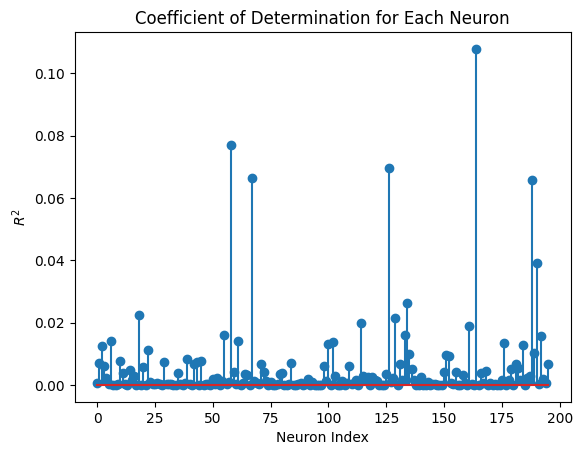

In [22]:
# TODO
# Rsq = ...
# Calculate variance for each neuron
variances = np.var(Xtr, axis=0)

# Filter out neurons with zero variance
nonzero_variance_neurons = variances > 0
Xtr_filtered = Xtr[:, nonzero_variance_neurons]

# Calculate the correlation between each filtered neuron's spikes and ytr
# np.corrcoef calculates the correlation matrix. We want the correlations between
# each column of Xtr_filtered and ytr.
# Stack ytr as a column to calculate correlation with each column of Xtr_filtered
corr_matrix = np.corrcoef(Xtr_filtered.T, ytr)

# The correlation coefficients between each neuron and ytr are in the last column (excluding the last element which is the correlation of ytr with itself)
Rsq_filtered = corr_matrix[:-1, -1]**2

# Create an Rsq array with the same size as the original number of neurons,
# filling with 0 for neurons with zero variance
Rsq = np.zeros(Xtr.shape[1])
Rsq[nonzero_variance_neurons] = Rsq_filtered

# plt.stem(...)
plt.stem(Rsq)
plt.xlabel('Neuron Index')
plt.ylabel('$R^2$')
plt.title('Coefficient of Determination for Each Neuron')

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=50` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [23]:
d = 50  # Number of neurons to use

# TODO
# Isel = ...
Isel = np.argsort(Rsq)[-d:] # Get the indices of the top d Rsq values
# print("The neurons with the ten highest R^2 values = ...)
print("The neurons with the ten highest R^2 values =", np.argsort(Rsq)[-10:])

The neurons with the ten highest R^2 values = [114 129  18 134 190 188  67 126  58 164]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [24]:
# TODO
# Select the features (neurons) with the highest Rsq values
Xtr_sel = Xtr[:, Isel]
Xts_sel = Xts[:, Isel]

# Fit a linear model using the selected neurons
reg_sel = sklearn.linear_model.LinearRegression()
reg_sel.fit(Xtr_sel, ytr)

# Predict on the test data
yts_pred = reg_sel.predict(Xts_sel)

# Measure and print the test RSS per sample and normalized test RSS
RSS_test = np.mean((yts_pred - yts)**2)
normalized_RSS_test = RSS_test / np.var(yts)
Rsq_test = 1 - normalized_RSS_test

print(f'The test RSS per sample with {d} selected neurons is: {RSS_test:.6f}')
print(f'The normalized test RSS with {d} selected neurons is: {normalized_RSS_test:.6f}')
print(f'The test R^2 with {d} selected neurons is: {Rsq_test:.6f}')

The test RSS per sample with 50 selected neurons is: 0.000963
The normalized test RSS with 50 selected neurons is: 0.495387
The test R^2 with 50 selected neurons is: 0.504613


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

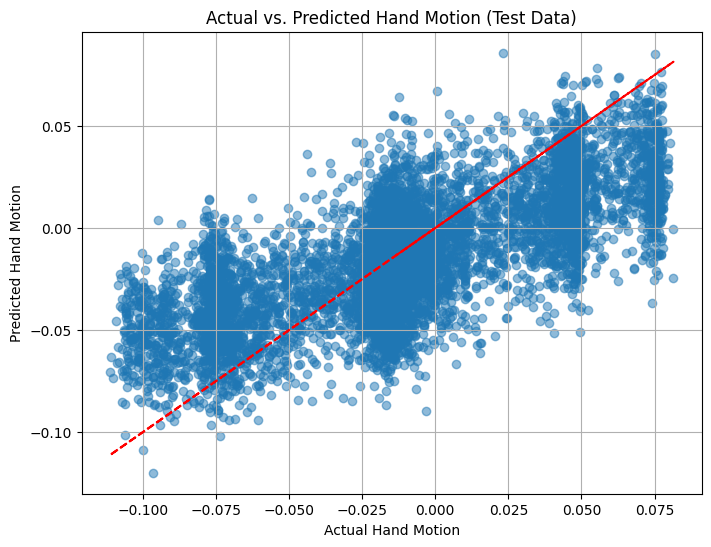

In [25]:
# TODO
plt.figure(figsize=(8, 6))
plt.scatter(yts, yts_pred, alpha=0.5)
plt.plot(yts, yts, color='red', linestyle='--') # Plot the line yts_hat = yts
plt.xlabel('Actual Hand Motion')
plt.ylabel('Predicted Hand Motion')
plt.title('Actual vs. Predicted Hand Motion (Test Data)')
plt.grid(True)
plt.show()

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=50`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [57]:
import  sklearn.model_selection
import sklearn.linear_model

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

# Initialize array to store RSS for each fold and each model order
RSS_test_fold = np.zeros((nd, nfold))
Rsq = np.corrcoef(Xtr.T, ytr)[:-1,-1]**2

# Iterate through model orders
for i, d in enumerate(dtest):
    print(f'Testing model order d = {d}')

    # Get the indices of the top d neurons based on Rsq
    Isel = np.argsort(Rsq)[-d:]

    # Iterate through folds
    for fold, (train_index, test_index) in enumerate(kf.split(Xtr)):
        # Split data into training and validation sets for the current fold
        X_train_fold, X_val_fold = Xtr[train_index, :][:, Isel], Xtr[test_index, :][:, Isel]
        y_train_fold, y_val_fold = ytr[train_index], ytr[test_index]

        # Fit a linear model on the training fold
        reg_fold = sklearn.linear_model.LinearRegression()
        reg_fold.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred = reg_fold.predict(X_val_fold)

        # Calculate normalized RSS on the validation fold
        # Add a small epsilon to the variance to avoid division by zero
        var_y_val = np.var(y_val_fold)
        if var_y_val < 1e-9: # Check if variance is close to zero
            RSS_test_fold[i, fold] = np.nan # Or handle as appropriate, e.g., assign a large value or skip
        else:
            RSS_test_fold[i, fold] = np.mean((y_val_pred - y_val_fold)**2) / var_y_val

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Testing model order d = 10
Testing model order d = 20
Testing model order d = 30
Testing model order d = 40
Testing model order d = 50
Testing model order d = 60
Testing model order d = 70
Testing model order d = 80
Testing model order d = 90
Testing model order d = 100
Testing model order d = 110
Testing model order d = 120
Testing model order d = 130
Testing model order d = 140
Testing model order d = 150
Testing model order d = 160
Testing model order d = 170
Testing model order d = 180
Testing model order d = 190


Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method.

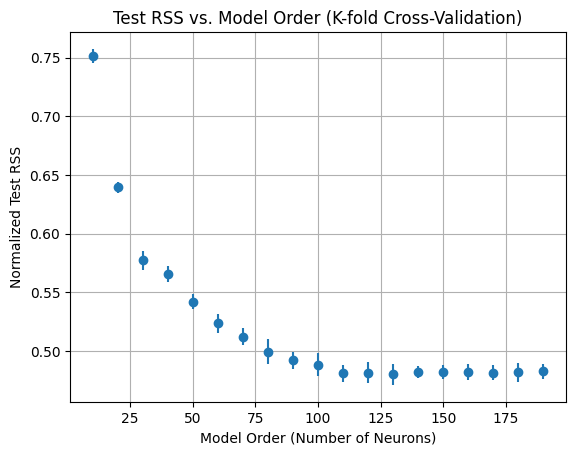

In [66]:
# TODO
# Compute the RSS test mean and standard error
RSS_test_mean = np.mean(RSS_test_fold, axis=1)
RSS_test_std  = np.std(RSS_test_fold, axis=1) / np.sqrt(nfold)

# Plot RSS vs. model order with error bars
plt.errorbar(dtest, RSS_test_mean, yerr=RSS_test_std, fmt = 'o')
plt.xlabel('Model Order (Number of Neurons)')
plt.ylabel('Normalized Test RSS')
plt.title('Test RSS vs. Model Order (K-fold Cross-Validation)')
plt.grid(True)
plt.show()

In [59]:
# TODO
# Find the minimum RSS mean
min_rss_mean = np.min(RSS_test_mean)

# Find the index of the minimum RSS mean
min_rss_idx = np.argmin(RSS_test_mean)

# Calculate the one standard error cutoff
one_std_error = RSS_test_mean[min_rss_idx] + RSS_test_std[min_rss_idx]

# Find the largest model order (d) whose mean RSS is within one standard error of the minimum
optimal_d_idx = np.max(np.where(RSS_test_mean <= one_std_error)[0])

# Get the optimal model order and its corresponding mean RSS
optimal_d = dtest[optimal_d_idx]
optimal_rss_mean = RSS_test_mean[optimal_d_idx]


The optimal model order (d) using the one standard error rule is: 190
The mean test RSS at the optimal d is: 0.482618


Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [68]:
# TODO
threshold = RSS_test_mean[optimal_d_idx] + RSS_test_std[optimal_d_idx]
good_model = np.where(RSS_test_mean <= threshold)[0]


print(f"The optimal model order (d) using the one standard error rule is: {optimal_d}")
print(f"The mean test RSS at the optimal d is: {optimal_rss_mean:.6f}")

The optimal model order (d) using the one standard error rule is: 190
The mean test RSS at the optimal d is: 0.482618


## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.